In [4]:
import os
import librosa
import numpy as np
import pywt

In [5]:
data_path = os.path.join(os.getcwd(), "recordings_actividad_7")  # Carpeta que contiene todos los audios.

# Función para cargar los datos
def load_data(data_path):
    labels = []
    features = []
    max_length = 0  # Para almacenar la longitud máxima de coeffs_flat
    
    # Primera pasada: encontrar la longitud máxima de coeffs_flat
    for file in os.listdir(data_path):
        if file.endswith(".wav"):
            file_path = os.path.join(data_path, file)
            audio, sr = librosa.load(file_path, sr=None)
            coeffs = pywt.wavedec(audio, 'db1', level=4)
            coeffs_flat = np.concatenate(coeffs)
            if len(coeffs_flat) > max_length:
                max_length = len(coeffs_flat)
    
    # Segunda pasada: rellenar o truncar los coeficientes
    for file in os.listdir(data_path):
        if file.endswith(".wav"):
            file_path = os.path.join(data_path, file)
            audio, sr = librosa.load(file_path, sr=None)
            coeffs = pywt.wavedec(audio, 'db1', level=4)
            coeffs_flat = np.concatenate(coeffs)
            
            # Rellenar con ceros si es necesario
            if len(coeffs_flat) < max_length:
                padding = max_length - len(coeffs_flat)
                coeffs_flat = np.pad(coeffs_flat, (0, padding), mode='constant')
            # Truncar si es necesario
            elif len(coeffs_flat) > max_length:
                coeffs_flat = coeffs_flat[:max_length]
            
            # Guardar características y etiquetas
            features.append(coeffs_flat)
            labels.append(int(file[0]))  # El primer carácter del nombre del archivo es la etiqueta
            
    return np.array(features), np.array(labels)

features, labels = load_data(data_path)

C:\Users\USER\anaconda33\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [6]:
print(f"Total de grabaciones: {len(features)}")


Total de grabaciones: 1373


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalizar características
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Construir el modelo
model = models.Sequential([
    layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Dropout en la primera capa densa, con 40% de desactivación
    layers.Dense(64, activation='relu'),  # Puedes agregar una segunda capa densa si lo prefieres
    layers.Dropout(0.4),  # Dropout después de la segunda capa densa también
    layers.Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

C:\Users\USER\anaconda33\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 10505, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 10503, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5251, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 5249, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2624, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 167936)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      21,495,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,511,178 (82.06 MB)

 Trainable params: 21,511,178 (82.06 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
#Si durante 3 epocas no se ve una mejora lo detiene
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Entrenar el modelo con EarlyStopping
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.2183 - loss: 3.1367 - val_accuracy: 0.2455 - val_loss: 1.8060
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.2809 - loss: 1.8646 - val_accuracy: 0.4955 - val_loss: 1.4942
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.3615 - loss: 1.5647 - val_accuracy: 0.4909 - val_loss: 1.3275
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.4968 - loss: 1.3245 - val_accuracy: 0.6591 - val_loss: 1.1413
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5388 - loss: 1.1384 - val_accuracy: 0.6591 - val_loss: 1.0365
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.5876 - loss: 1.0293 - val_accuracy: 0.6864 - val_loss: 0.9350
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - accuracy: 0.6545 - loss: 0.8361 - val_accuracy: 0.7045 - val_loss: 0.8885
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.7198 - loss: 0.7563 - val_accuracy: 0.

In [10]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7566 - loss: 1.4324
Precisión en el conjunto de prueba: 0.7491


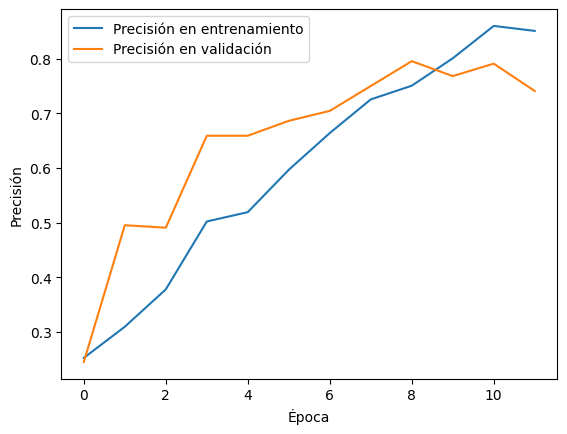

In [11]:
import matplotlib.pyplot as plt

# Graficar precisión y pérdida
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluación en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las predicciones a clases

# Filtrar las predicciones para que solo se consideren las clases de speakers 1, 2 y 3
# Cambiar las clases fuera del rango 1-3 a una clase específica (por ejemplo, clase '4')
y_pred_classes = np.where((y_pred_classes >= 1) & (y_pred_classes <= 3), y_pred_classes, 4)

# Mostrar el informe de clasificación (solo para las clases 1, 2, 3 y clase "4" para otras predicciones)
report = classification_report(y_test, y_pred_classes, labels=[1, 2, 3, 4], target_names=["Speaker 1", "Speaker 2", "Speaker 3", "Other"])
print("Informe de clasificación:")
print(report)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Informe de clasificación:
              precision    recall  f1-score   support

   Speaker 1       0.89      0.86      0.87        64
   Speaker 2       0.72      0.67      0.69        57
   Speaker 3       0.65      0.68      0.67        60
       Other       0.32      1.00      0.48        31

   micro avg       0.60      0.78      0.68       212
   macro avg       0.64      0.80      0.68       212
weighted avg       0.69      0.78      0.71       212



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7566 - loss: 1.4324
Precisión en el conjunto de prueba: 0.7491
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Informe de clasificación:
              precision    recall  f1-score   support

   Speaker 1       0.89      0.86      0.87        64
   Speaker 2       0.72      0.67      0.69        57
   Speaker 3       0.65      0.68      0.67        60
       Other       0.32      1.00      0.48        31

   micro avg       0.60      0.78      0.68       212
   macro avg       0.64      0.80      0.68       212
weighted avg       0.69      0.78      0.71       212



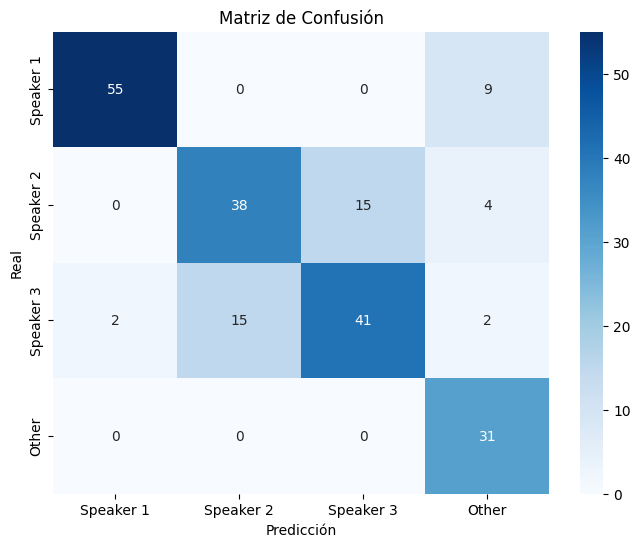

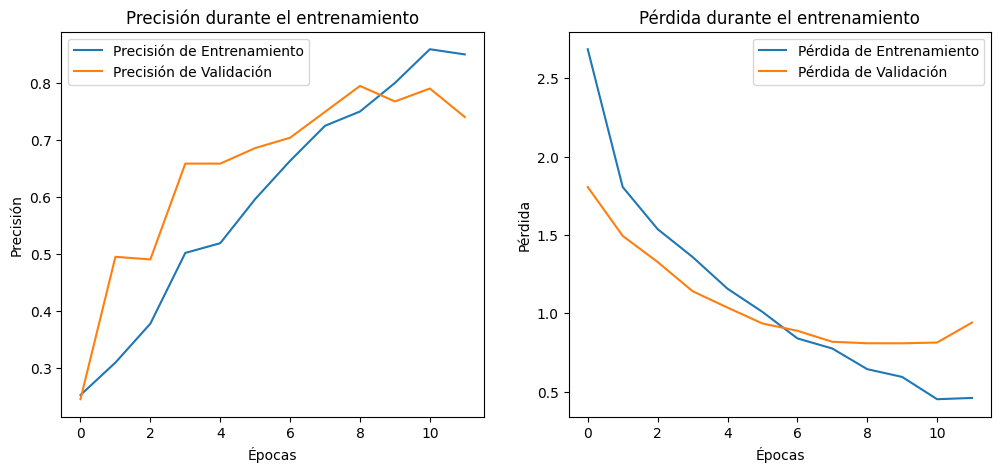

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Obtener las predicciones del modelo
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Filtrar las predicciones para que solo se consideren las clases 1, 2, 3, 4 (Other)
y_pred_classes = np.where((y_pred_classes >= 1) & (y_pred_classes <= 3), y_pred_classes, 4)

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred_classes, labels=[1, 2, 3, 4], target_names=["Speaker 1", "Speaker 2", "Speaker 3", "Other"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes, labels=[1, 2, 3, 4])

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Speaker 1", "Speaker 2", "Speaker 3", "Other"], 
            yticklabels=["Speaker 1", "Speaker 2", "Speaker 3", "Other"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Gráficos de entrenamiento
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

